### Import Required Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 12, 'figure.figsize': (10, 5)})
import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_absolute_error

###  Load the Dataset 

In [2]:
data = pd.read_csv('datasets/data.csv')
print(data.shape)
data.sample(3)

(100000, 34)


,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
74149,-0.48,-1.02,0,7,11:00,11:39,17:00,17:50,17:00,17:20,09:00,09:21,07:00,07:28,15:00,15:05,13:00,13:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3237,1.03,-2.07,1,4,07:00,21:56,18:00,08:10,20:00,20:20,15:00,23:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52961,0.06,2.27,2,1,19:00,14:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data & Task Description

<div>N users (N=100.000), every user data lays in separate row (i.e. you have 100K rows for 100K users)</div>
<ul>
<li>X[i] - features of i-th user, i in [1..N]</li>
<li>X[i][0] - feature 1 (numerical)</li>
<li>X[i][1] - feature 2 (numerical)</li>
<li>X[i][2] - feature 3 (categorical)</li>
<li>M[i] - number of emails sent to i-th user (1 <= M[i] <= 15), Mi is not the same for every user i, (for instance M[1] could be 10, M[2] could be 5)</li>
<li>TS[i][j] - time of j-th email sending to i-th user, j in [1..M[i]]</li>
<li>TO[i][j] - time of j-th email opening by i-th user, j in [1..M[i]]</li>
</ul>
<div>NOTE: If TS[i][j] > TO[i][j], then TO[i][j] belongs to the next day (for instance if sending time is
14:00 and opening time is 10:00, then it’s 10:00 of the next day)</div>

<b>Goal:</b> given features of new user X predict the sending time TS so that opening time TO will
be as early as possible, i.e (TO-TS) -> min

The task in this case study is also known as the 'Send Time Optimization' problem, which is one of the most interesting problems for marketing intelligence using machine learning and/or optimization based approaches. There are various methods can be employed to solve it (e.g. A/B testing, multi-armed bandit algorithm, reinforcement learning, etc.), but most of them require some degree of experimentation (which might be not feasible for this task). Here, I'm going to present a model-based approach using the combination of supervised learning (i.e. classification and regression) and unsupervised learning (i.e. clustering) models.

Initially, I tried to convert the timestamp data (TOs and TSs) into the datetime format. However, I got some errors because some numbers are negative (see column 'TS01' below). I'll manually fix these as I assume there some typos in the following rows.

In [3]:
data[data['TO01'].isin(['00:-53', '-1:-6'])]

,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
4881,0.06,-0.62,0,11,15:00,07:52,10:00,00:-53,13:00,22:07,09:00,20:51,08:00,13:44,10:00,19:11,19:00,22:27,08:00,12:21,07:00,21:29,14:00,17:00,12:00,23:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97375,0.56,0.01,0,13,17:00,17:15,09:00,-1:-6,09:00,09:56,11:00,07:34,09:00,08:02,15:00,11:00,17:00,08:22,19:00,17:48,10:00,13:50,16:00,22:33,12:00,10:22,12:00,10:15,16:00,09:21,NaN,NaN,NaN,NaN


In [4]:
data.iloc[4881, 7] = '00:53'
data.iloc[97375, 7] = '01:06'

### Data Preparation

Let's create a column for 'user_id' by directly using the dataframe index.

In [5]:
data.index.name = 'user_id'
data = data.reset_index()
data.sample(3)

,user_id,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
3028,3028,0.93,-0.80,3,1,09:00,21:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60445,60445,-1.88,-1.24,1,7,12:00,20:44,16:00,09:05,16:00,21:12,16:00,09:14,19:00,08:29,10:00,22:39,12:00,19:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80768,80768,-0.92,-2.94,3,10,20:00,20:22,10:00,10:58,19:00,21:07,13:00,15:33,15:00,15:39,13:00,13:06,19:00,19:29,09:00,09:48,20:00,20:06,13:00,15:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then, define the group of features, as follows.

In [6]:
profiles = ['user_id', 'X1', 'X2', 'X3']
sendings = [i for i in data.columns if i.startswith('TS')]
openings = [i for i in data.columns if i.startswith('TO')]

#### Validation Set

To evaluate the performance of my proposed approach (as will be explained below), split the dataset into training and validation sets. I'll just take 20% of the initial dataset as the validation set.

In [7]:
test_set = data.sample(int(data.shape[0] * 0.2), random_state=42)
test_set.shape

(20000, 35)

Remove the validation set from the initial dataset to get the training set.

In [8]:
train_set = data.drop(test_set.index)
train_set.shape

(80000, 35)

#### Activity-level Data

Next, I'm going to do some transformation on the original dataset to get a new data on the activity level (i.e. each row represents one email being sent and opened), and engineering some new features out of them.

To begin, I need to melt both TS and TO variables. I'll do it separately, then merge the result together. To help the merging process I'm going to create a temporary column as the key to join the dataframes, by concatenating the user_id and the index for TS/TO columns.

In [9]:
ts_melted = pd.melt(train_set, id_vars=['user_id'], value_vars=sendings, var_name='Tx', value_name='TS')
ts_melted['Tx'] = ts_melted['user_id'].astype('str') + '-' + ts_melted['Tx'].str[-2:]  #the helper key
print(ts_melted.shape)
ts_melted.sample(5)

(1200000, 3)


,user_id,Tx,TS
1092292,65375,65375-13,NaN
162094,2626,2626-02,NaN
472683,90862,90862-05,18:00
549684,87080,87080-06,20:00
136922,71181,71181-01,18:00


In [10]:
to_melted = pd.melt(train_set, id_vars=['user_id'], value_vars=openings, var_name='Tx', value_name='TO')
to_melted['Tx'] = to_melted['user_id'].astype('str') + '-' + to_melted['Tx'].str[-2:]
print(to_melted.shape)
to_melted.sample(5)

(1200000, 3)


,user_id,Tx,TO
859180,74006,74006-10,13:05
166351,7934,7934-02,22:03
1043464,4339,4339-13,NaN
552114,90157,90157-06,NaN
261328,26662,26662-03,12:34


Merge the melted dataframes together with the user-profiles. As the order of the received emails (M=0,1,2,...) for one user can be assumed completely random, the temporary 'Tx' column can be discarded. Also, all NaN rows can be safely dropped.

In [11]:
df_melted = pd.merge(ts_melted, to_melted.drop('user_id', axis=1), on='Tx', how='inner')
df_joined = pd.merge(train_set[profiles], df_melted, on='user_id', how='inner')
df_joined.drop('Tx', axis=1, inplace=True)
df_joined.dropna(inplace=True)
print(df_joined.shape)
df_joined.sample(5)

(639771, 6)


,user_id,X1,X2,X3,TS,TO
1080365,90045,0.52,-0.19,1,20:00,12:18
591538,49325,0.06,-2.98,0,08:00,09:59
957306,79797,-0.84,2.06,0,15:00,15:46
633498,52813,-0.85,-1.57,0,12:00,12:48
620236,51713,0.37,-0.10,1,15:00,20:09


Calculate the time difference between email-being-sent and email-opened. I can either evaluate this in minutes or hours, but as minutes is probably too granular, I'm going to use hours instead.

In [12]:
act_data = df_joined.copy()
act_data['TS'] = pd.to_datetime(act_data['TS'], format='%H:%M')
act_data['TO'] = pd.to_datetime(act_data['TO'], format='%H:%M')

#if TS is earlier than TO
act_data.loc[act_data['TO']>=act_data['TS'], 'mins_to_open'] = (act_data['TO'] - act_data['TS']).dt.total_seconds()/60
#otherwise, add 24 hours for the next day
act_data.loc[act_data['TO']<act_data['TS'], 'mins_to_open'] = (act_data['TO'] - act_data['TS'] + timedelta(hours=24)) \
                                                                .dt.total_seconds()/60
act_data['hours_to_open'] = np.ceil(act_data['mins_to_open']/60)

act_data['TO_hour_of_day'] = act_data['TO'].dt.hour
act_data['TO_min_of_day'] = act_data['TO'].dt.hour * 60 + act_data['TO'].dt.minute

TS and TO columns may contain irrelevant dates after conversion, but as it will not affect anything, I'll just ignore them for now.

Let's visualize the distribution of users opening email over time within a day.

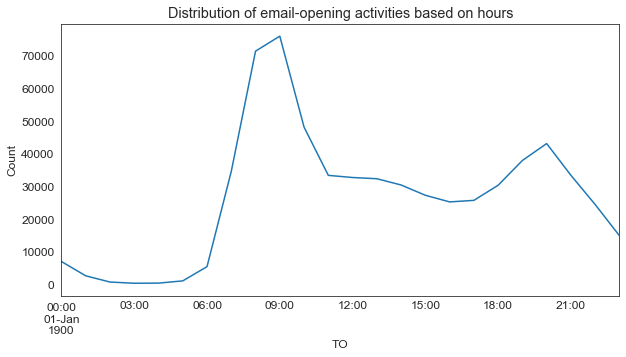

In [13]:
act_data.set_index('TO').resample('H').count()['user_id'].plot()
plt.ylabel('Count')
plt.title('Distribution of email-opening activities based on hours')
plt.show()

As seen, there are some peaks where most people open their emails. Following this, I think I can create groups of period of time, such as: 'Midnight' - between 12-6 am, 'Morning' - between 6 am-12 pm, 'Noon' - between 12-6 pm, and 'Evening' - between 6 pm-12 am.

In [14]:
b = [0, 6 ,12, 18, 24]
l = ['Midnight', 'Morning', 'Noon', 'Evening']

act_data['TO_period'] = pd.cut(act_data['TO'].dt.hour, bins=b, labels=l, include_lowest=True)
act_data.sample(5)

,user_id,X1,X2,X3,TS,TO,mins_to_open,hours_to_open,TO_hour_of_day,TO_min_of_day,TO_period
1029978,85801,1.23,0.14,0,1900-01-01 12:00:00,1900-01-01 08:26:00,1226.0,21.0,8,506,Morning
2521,201,-0.78,-1.37,2,1900-01-01 14:00:00,1900-01-01 17:39:00,219.0,4.0,17,1059,Noon
259571,21673,-0.52,-1.66,3,1900-01-01 07:00:00,1900-01-01 07:19:00,19.0,1.0,7,439,Morning
14450,1211,-0.86,-0.64,3,1900-01-01 10:00:00,1900-01-01 10:00:00,0.0,0.0,10,600,Morning
799239,66612,-1.52,-3.86,3,1900-01-01 11:00:00,1900-01-01 12:08:00,68.0,2.0,12,728,Morning


Then the question is, can I create groups of users according to their behaviors in opening emails? There are several ways to do this: 1) find the most frequent 'TO_period', 2) find the mean of the hours to open emails and convert to period of time, 3) find the median of the hours to open emails and convert to period of time, and 4) using unsupervised learning to cluster the users.

#### User-level Data

Let's go back to the user-level features (after removing the TSs and TOs), and engineer new features as well.

As generating the most frequent period of time may take some time to complete, to save time for the consequent iterations, I have saved this dataframe into a .csv file, and load whenever necessary.

In [15]:
def period_from_hour(h):
    if h >= 0 and h < 6:
        return 'Midnight'
    elif h >= 6 and h < 12:
        return 'Morning'
    elif h >= 12 and h < 18:
        return 'Noon'
    elif h >= 18 and h < 24:
        return 'Evening'

In [16]:
generated = False  #True, for the first run, and to generate the dataframe and save into csv

if generated:

    user_data = pd.DataFrame()
    
    user_data['avg_hours_to_open'] = act_data.groupby('user_id').mean()['hours_to_open']
    user_data['med_hours_to_open'] = act_data.groupby('user_id').median()['hours_to_open']
    user_data['std_hours_to_open'] = act_data.groupby('user_id').std()['hours_to_open']
    user_data['std_hours_to_open'].fillna(0, inplace=True)  #same as above
    
    user_data['mean_TO_period'] = (act_data.groupby('user_id').mean()['TO_hour_of_day']).apply(period_from_hour)
    user_data['med_TO_period'] = (act_data.groupby('user_id').median()['TO_hour_of_day']).apply(period_from_hour)
    user_data['mod_TO_period'] = act_data.groupby('user_id').agg(lambda x: x.value_counts().index[0])['TO_period']
    
    user_data.reset_index(inplace=True)
    
    user_data = pd.merge(train_set[profiles], user_data, on='user_id', how='inner')
    
else:
    
    user_data = pd.read_csv('datasets/user-lvl-data.csv')

print(user_data.shape)
user_data.sample(5)

(80000, 10)


,user_id,X1,X2,X3,avg_hours_to_open,med_hours_to_open,std_hours_to_open,mean_TO_period,med_TO_period,mod_TO_period
59964,74995,0.68,-0.68,3,1.000000,1.0,0.000000,Noon,Noon,Noon
3115,3902,-0.18,0.12,3,1.090909,1.0,0.539360,Noon,Noon,Morning
21347,26691,-0.65,0.85,3,1.250000,1.0,0.452267,Noon,Noon,Morning
61965,77471,0.06,0.69,1,7.666667,2.0,10.692677,Morning,Morning,Morning
61438,76833,-0.19,1.15,0,1.000000,1.0,0.000000,Noon,Noon,Noon


#### Clustering-based Approach

Next, create clusters of users based on their behavior in opening emails using K-Means. But, first let's create a pivot table capturing time to open email from each user.

In [17]:
act_pvt = act_data[['user_id', 'TO']]
act_pvt['hour_opened'] = act_pvt['TO'].dt.hour
act_pvt = pd.DataFrame(pd.pivot_table(act_pvt, index='user_id', columns='hour_opened', aggfunc='count') \
                       .fillna(0).to_records())
print(act_pvt.shape)
act_pvt.sample(5)

(80000, 25)


,user_id,"('TO', 0)","('TO', 1)","('TO', 2)","('TO', 3)","('TO', 4)","('TO', 5)","('TO', 6)","('TO', 7)","('TO', 8)","('TO', 9)","('TO', 10)","('TO', 11)","('TO', 12)","('TO', 13)","('TO', 14)","('TO', 15)","('TO', 16)","('TO', 17)","('TO', 18)","('TO', 19)","('TO', 20)","('TO', 21)","('TO', 22)","('TO', 23)"
14853,18569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0
26289,32860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,3.0,2.0,1.0,2.0
14151,17706,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0
48473,60638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78053,97589,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0


Find the most optimum k with the elbow method.

In [18]:
def calculate_WSS(points, kmax):
    ssd = []
    K = range(2, kmax+1)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(points)
        ssd.append(km.inertia_)
        
    return ssd

ssd = calculate_WSS(act_pvt.drop('user_id', axis=1), 10)

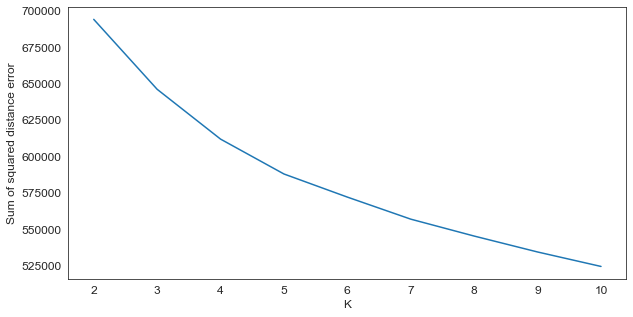

In [19]:
plt.plot(list(range(2, len(ssd)+2)), ssd)
plt.xlabel('K')
plt.ylabel('Sum of squared distance error')
plt.show()

It seems difficult to find the right k from this figure. I'll try using k=3, and visualize to see if it correctly clusters the users. Separately, I've also tried k=4, but as k=3 gave better clusters, I'll go with it.

In [20]:
num_of_cluster = 3
kmeans = KMeans(n_clusters=num_of_cluster, random_state=42).fit(act_pvt.drop('user_id', axis=1))
act_pvt['cluster'] = kmeans.labels_

act_cluster = pd.merge(act_data[['user_id', 'TO']], act_pvt[['user_id', 'cluster']], how='inner', on='user_id')
print(act_cluster.shape)
act_cluster.sample(5)

(639771, 3)


,user_id,TO,cluster
237272,37196,1900-01-01 23:14:00,2
376076,58993,1900-01-01 19:05:00,1
212139,33310,1900-01-01 09:41:00,1
493124,77214,1900-01-01 14:48:00,1
151294,23875,1900-01-01 19:02:00,2


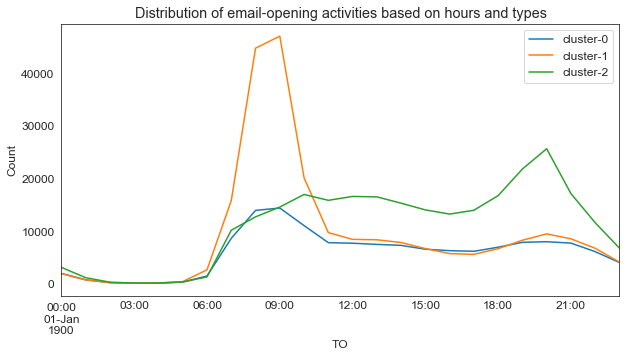

In [21]:
for i in range(num_of_cluster):
    act_cluster[act_cluster['cluster']==i].set_index('TO').resample('H').count()['user_id'].plot(label='cluster-' + str(i))

plt.ylabel('Count')
plt.title('Distribution of email-opening activities based on hours and types')
plt.legend()
plt.show()

Looks good so far. The algorithm clearly separated users who are typically active in the morning, in the evening, and indistinguishable (or with tendency to the morning). Let's merge this with the user-level data.

In [22]:
user_data = pd.merge(user_data, act_pvt[['user_id', 'cluster']], how='inner', on='user_id')
print(user_data.shape)
user_data.sample(5)

(80000, 11)


,user_id,X1,X2,X3,avg_hours_to_open,med_hours_to_open,std_hours_to_open,mean_TO_period,med_TO_period,mod_TO_period,cluster
39937,49965,-2.29,-1.14,1,12.928571,12.0,6.696317,Noon,Evening,Evening,1
70167,87667,-0.36,1.17,1,10.666667,11.0,7.257180,Noon,Evening,Evening,0
12592,15765,0.04,-2.51,1,16.125000,19.5,8.096516,Noon,Noon,Noon,2
65395,81775,0.58,-0.44,2,7.428571,4.0,7.303469,Noon,Noon,Evening,2
64195,80256,-0.30,1.06,0,0.666667,1.0,0.577350,Morning,Morning,Morning,0


#### Mixture Model

I'm curious more about the average hour to open emails. Let's visualize it.

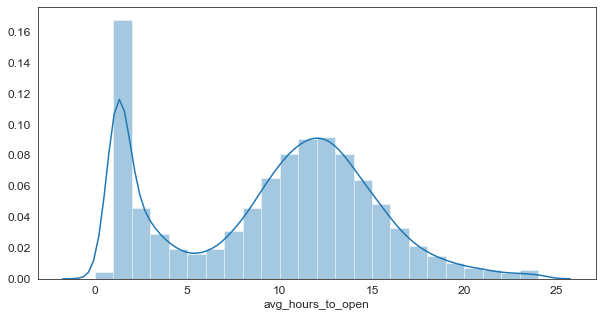

In [23]:
sns.distplot(user_data['avg_hours_to_open'], bins=24)
plt.show()

The distribution is bimodal, which means there are 2 types of users: 1) those who open their emails relatively quickly, and 2) the rest of the population, who may open their emails based on time. Next, I'm going to use Gaussian Mixture Model to separate these 2 populations. For simplification, I'll refer them as user type-0 and type-1.

In [30]:
gmm = GaussianMixture(n_components=2)
gmm.fit(user_data[['avg_hours_to_open']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

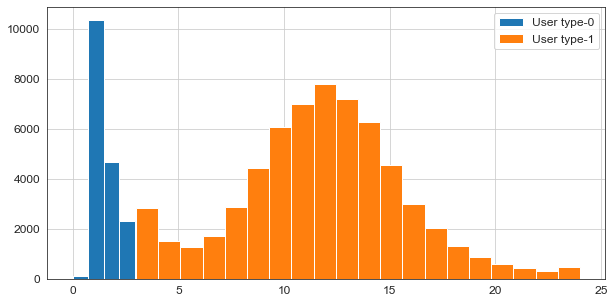

In [31]:
dists = gmm.predict(user_data[['avg_hours_to_open']])
user_data['dist'] = dists
user_data[user_data['dist']==0]['avg_hours_to_open'].hist(bins=4, label='User type-0')
user_data[user_data['dist']==1]['avg_hours_to_open'].hist(bins=20, label='User type-1')
plt.legend()
plt.show()

Okay, it is relatively representative of the original distribution. Let's add this into a new column in the user-level data.

In [32]:
user_data.sample(5)

,user_id,X1,X2,X3,avg_hours_to_open,med_hours_to_open,std_hours_to_open,mean_TO_period,med_TO_period,mod_TO_period,cluster,dist
78328,97927,-0.18,1.86,3,1.466667,1.0,0.639940,Noon,Noon,Noon,2,0
35874,44913,-0.19,-0.81,3,1.500000,1.5,0.547723,Noon,Noon,Morning,0,0
10839,13589,-0.75,1.65,3,1.714286,1.0,1.253566,Noon,Noon,Evening,2,0
2430,3052,-0.80,0.85,2,9.000000,7.0,9.416298,Morning,Morning,Morning,0,1
51435,64340,-0.55,-2.34,0,2.636364,1.0,5.445599,Noon,Noon,Noon,2,0


In [33]:
act_with_dist = pd.merge(act_data[['user_id', 'hours_to_open']], user_data[['user_id', 'dist']], on='user_id', how='inner')
perfm = pd.concat([act_with_dist.groupby('dist').mean()['hours_to_open'],
           act_with_dist.groupby('dist').median()['hours_to_open'],
           act_with_dist.groupby('dist').count()['hours_to_open']], axis=1, keys=['Mean (h)', 'Median (h)', 'Count'])
print('Whole-population mean:', (perfm['Mean (h)'] * perfm['Count']).sum() / perfm['Count'].sum())
perfm

Whole-population mean: 9.553826290969738


,Mean (h),Median (h),Count
dist,,,
0,1.593966,1.0,132819
1,11.639272,12.0,506952


As expected, the user type-0 population has a very small mean/median of the hours-to-open-emails. I think it makes more sense to separate these two populations first, and optimize the not-so-good one (i.e. user type-1)

### Building Predictive Models for Send-Time Optimization

Now that I have several potential target variables, let's try building some predictive models based on supervised learning approach. First, let's define the baseline performance, which is the mean/median of hours to open emails from the total population (note: I'm also checking median to see if the data is normally distributed or potentially consists of outliers.

In [34]:
pd.concat([act_data[['hours_to_open']].mean(),
           act_data[['hours_to_open']].median()], axis=1, keys=['Mean (h)', 'Median (h)'])

,Mean (h),Median (h)
hours_to_open,9.553826,7.0


#### Naive Model

Next, let's try the most naive model where all emails are sent at the same time. According to the visualization above, most activities starts around 6 am. Let's change TSs to this value.

In [35]:
naive = act_data[['TO']].copy()
naive['TS_hat'] = datetime.strptime('06:00', '%H:%M')

#if TS is earlier than TO
naive.loc[naive['TO']>=naive['TS_hat'], 'mins_to_open'] = (naive['TO'] - naive['TS_hat']).dt.total_seconds()/60
#otherwise, add 24 hours for the next day
naive.loc[naive['TO']<naive['TS_hat'], 'mins_to_open'] = (naive['TO'] - naive['TS_hat'] + timedelta(hours=24)) \
                                                                .dt.total_seconds()/60
naive['hours_to_open'] = np.ceil(naive['mins_to_open']/60)

pd.concat([naive[['hours_to_open']].mean(),
           naive[['hours_to_open']].median()], axis=1, keys=['Mean (h)', 'Median (h)'])

,Mean (h),Median (h)
hours_to_open,8.88602,8.0


This approach can bring the average time down a little, and the median closer (more normally distributed). Let's continue with predictive models.

#### Classification Models

Using user features, I'm going to train 5 classifiers to predict the mean, median, and most frequent period of time to open emails, as well as the type of distribution, and cluster assignment. Let's create a machine learning pipeline for this, and evaluate the performances with cross validation.

In [36]:
num_vars = ['X1', 'X2']
cat_vars = ['X3']

num_transform = Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transform = Pipeline(steps=[('ohe', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_features', num_transform, num_vars),
        ('categorical_features', cat_transform, cat_vars)
    ])

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [37]:
targets = ['mean_TO_period', 'med_TO_period', 'mod_TO_period', 'cluster', 'dist']
sampled = user_data.sample(10000)
X = sampled[['X1', 'X2', 'X3']]

for target in targets:

    y = sampled[target]
    if (y.nunique()>2):
        y = pd.get_dummies(y.astype('category'))
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #clf_pipeline.fit(X_train, y_train)
    #y_pred = clf_pipeline.predict(X_test)
    #print('Accuracy [', target, ']:', accuracy_score(y_test, y_pred))
    
    crossval = cross_val_score(clf_pipeline, X, y, cv=5, scoring='accuracy')
    print('Accuracy [', target, ']:', np.mean(crossval), '(std =', np.std(crossval) , ')')

Accuracy [ mean_TO_period ]: 0.7167 (std = 0.004643274706497571 )
Accuracy [ med_TO_period ]: 0.5402 (std = 0.007678541528180979 )
Accuracy [ mod_TO_period ]: 0.4856 (std = 0.010711675872616748 )
Accuracy [ cluster ]: 0.4022 (std = 0.006144916598294877 )
Accuracy [ dist ]: 0.9338999999999998 (std = 0.0034554305086341797 )


The key takeaways from these: 1) the type of users' behavior can be predicted accurately from the user features, 2) the mean of period of time to open emails seems to work better as the target variable compared to the mode or median, 3) clustering-based label doesn't seem to work as good as expected.

From here, I'm going to pick the 1st and 5th-classifier (mean period of time, and distribution prediction) to be considered in the further steps. The way it works:
<ul>
    <li>Using the 5th-classifier, predict whether a user falls in the type-0 or the type-1 distribution.</li>
    <li>As observed previously, user type-0 opens their email pretty regularly, so sending emails to this type of user should be fine at any time.</li>
    <li>As the send-time for user type-1 needs to be optimized, using the 1st-classifier, predict what period of time most likely users will open email. Assign the most optimum send time based on groups.</li>
</ul>

### Model Evaluation

Let's check this using the evaluation set. First, let's transform the evaluation set using the same steps as previously. Then, re-train the model using the whole training set.

In [40]:
ts_melted = pd.melt(test_set, id_vars=['user_id'], value_vars=sendings, var_name='Tx', value_name='TS')
ts_melted['Tx'] = ts_melted['user_id'].astype('str') + '-' + ts_melted['Tx'].str[-2:]  #the helper key
to_melted = pd.melt(test_set, id_vars=['user_id'], value_vars=openings, var_name='Tx', value_name='TO')
to_melted['Tx'] = to_melted['user_id'].astype('str') + '-' + to_melted['Tx'].str[-2:]

df_melted = pd.merge(ts_melted, to_melted.drop('user_id', axis=1), on='Tx', how='inner')
df_joined = pd.merge(test_set[profiles], df_melted, on='user_id', how='inner')
df_joined.drop('Tx', axis=1, inplace=True)
df_joined.dropna(inplace=True)

act_data_test = df_joined.copy()
act_data_test['TS'] = pd.to_datetime(act_data_test['TS'], format='%H:%M')
act_data_test['TO'] = pd.to_datetime(act_data_test['TO'], format='%H:%M')
#if TS is earlier than TO
act_data_test.loc[act_data_test['TO']>=act_data_test['TS'], 'mins_to_open'] = (act_data_test['TO'] - act_data_test['TS']).dt.total_seconds()/60
#otherwise, add 24 hours for the next day
act_data_test.loc[act_data_test['TO']<act_data_test['TS'], 'mins_to_open'] = (act_data_test['TO'] - act_data_test['TS'] + timedelta(hours=24)) \
                                                                .dt.total_seconds()/60
act_data_test['hours_to_open'] = np.ceil(act_data_test['mins_to_open']/60)
act_data_test['TO_hour_of_day'] = act_data_test['TO'].dt.hour

user_data_test = pd.DataFrame()
user_data_test['avg_hours_to_open'] = act_data_test.groupby('user_id').mean()['hours_to_open']
user_data_test['mean_TO_period'] = (act_data_test.groupby('user_id').mean()['TO_hour_of_day']).apply(period_from_hour)
user_data_test.reset_index(inplace=True)
user_data_test = pd.merge(test_set[profiles], user_data_test, on='user_id', how='inner')

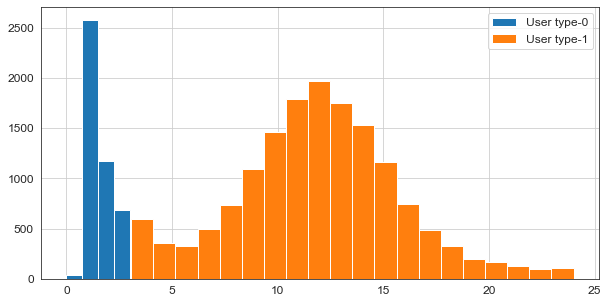

In [41]:
gmm = GaussianMixture(n_components=2)
gmm.fit(user_data_test[['avg_hours_to_open']])
dists = gmm.predict(user_data_test[['avg_hours_to_open']])
user_data_test['dist'] = dists

user_data_test[user_data_test['dist']==0]['avg_hours_to_open'].hist(bins=4, label='User type-0')
user_data_test[user_data_test['dist']==1]['avg_hours_to_open'].hist(bins=20, label='User type-1')
plt.legend()
plt.show()

#### Baseline Performance

Baseline performance on the evaluation set.

In [42]:
pd.concat([act_data_test[['hours_to_open']].mean(),
           act_data_test[['hours_to_open']].median()], axis=1, keys=['Mean (h)', 'Median (h)'])

,Mean (h),Median (h)
hours_to_open,9.578444,7.0


#### Naive Model

Let's apply the naive model to the evaluation set, and see how the performance.

In [43]:
naive = act_data_test[['TO']].copy()
naive['TS_hat'] = datetime.strptime('06:00', '%H:%M')

#if TS is earlier than TO
naive.loc[naive['TO']>=naive['TS_hat'], 'mins_to_open'] = (naive['TO'] - naive['TS_hat']).dt.total_seconds()/60
#otherwise, add 24 hours for the next day
naive.loc[naive['TO']<naive['TS_hat'], 'mins_to_open'] = (naive['TO'] - naive['TS_hat'] + timedelta(hours=24)) \
                                                                .dt.total_seconds()/60
naive['hours_to_open'] = np.ceil(naive['mins_to_open']/60)

pd.concat([naive[['hours_to_open']].mean(),
           naive[['hours_to_open']].median()], axis=1, keys=['Mean (h)', 'Median (h)'])

,Mean (h),Median (h)
hours_to_open,8.890275,8.0


Both baseline and naive-model perform similarly when applied to the training set.

#### Classification Model

In [44]:
X_train = user_data[['X1', 'X2', 'X3']]
y_train = user_data['dist']
X_val = user_data_test[['X1', 'X2', 'X3']]
y_val = user_data_test['dist']

clf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric_features',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['X1', 'X2']),
                                                 ('categorical_features',
                                     

In [45]:
y_pred = clf_pipeline.predict(X_val)
print('Accuracy:', accuracy_score(y_pred, y_val))

Accuracy: 0.92125


In [58]:
user_type1 = user_data[user_data['dist']==1]

user_data_test['dist_hat'] = y_pred

user_type0_test = user_data_test[user_data_test['dist_hat']==0]
user_type1_test = user_data_test[user_data_test['dist_hat']==1]

Predict the period of time for users to open emails.

In [62]:
X_train3 = user_type1[['X1', 'X2', 'X3']]
y_train3 = pd.get_dummies(user_type1['mean_TO_period'].astype('category'))
X_val3 = user_type1_test[['X1', 'X2', 'X3']]
y_val3 = pd.get_dummies(user_type1_test['mean_TO_period'].astype('category'))

clf_pipeline.fit(X_train3, y_train3)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric_features',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['X1', 'X2']),
                                                 ('categorical_features',
                                     

In [63]:
y_pred3 = clf_pipeline.predict(X_val3)
print('Accuracy:', accuracy_score(y_pred3, y_val3))

Accuracy: 0.6816496454823392


In [64]:
periods = y_val3.columns.tolist()
user_type1_test['mean_TO_period_hat'] = [periods[np.argmax(y)] for y in y_pred3]

Now, let's create prediction for the sending time that might minimize the time to open the emails. I'm going to use the GridSearch approach to find the most optimum time to send emails for each of group.

In [53]:
def hour_from_period(period, params):
    
    if period=='Midnight':
        return datetime.strptime(params[0], '%H:%M')
    elif period=='Morning':
        return datetime.strptime(params[1], '%H:%M')
    elif period=='Noon':
        return datetime.strptime(params[2], '%H:%M')
    elif period=='Evening':
        return datetime.strptime(params[3], '%H:%M')

In [65]:
params = {
    'midnight': ['23:00', '00:00', '01:00'],
    'morning': ['05:00', '06:00', '07:00'],
    'noon': ['11:00', '12:00', '13:00'],
    'evening': ['17:00', '18:00', '19:00']
}
grid = ParameterGrid(params)
all_means = []
all_medians = []

temp0 = pd.merge(act_data_test[['user_id', 'TS', 'TO']], user_type0_test[['user_id', 'dist_hat']],
                on='user_id', how='right')
temp0['TS_hat'] = temp0['TS']
temp0.loc[temp0['TO']>=temp0['TS_hat'], 'mins_to_open'] = (temp0['TO'] - temp0['TS_hat']).dt.total_seconds()/60
temp0.loc[temp0['TO']<temp0['TS_hat'], 'mins_to_open'] = (temp0['TO'] - temp0['TS_hat'] + timedelta(hours=24)) \
                                                                .dt.total_seconds()/60
temp0['hours_to_open'] = np.ceil(temp0['mins_to_open']/60)

for g in grid:

    params = [g['midnight'], g['morning'], g['noon'], g['evening']]

    user_type1_test['TS_hat'] = user_type1_test['mean_TO_period_hat'].apply(lambda x: hour_from_period(x, params))
    temp1 = pd.merge(act_data_test[['user_id', 'TS', 'TO']], user_type1_test[['user_id', 'TS_hat', 'dist_hat']],
                    on='user_id', how='right')
    temp1.loc[temp1['TO']>=temp1['TS_hat'], 'mins_to_open'] = (temp1['TO'] - temp1['TS_hat']).dt.total_seconds()/60
    temp1.loc[temp1['TO']<temp1['TS_hat'], 'mins_to_open'] = (temp1['TO'] - temp1['TS_hat'] + timedelta(hours=24)) \
                                                                    .dt.total_seconds()/60
    temp1['hours_to_open'] = np.ceil(temp1['mins_to_open']/60)

    time_prediction = pd.concat([temp0, temp1])
    
    all_means.append(time_prediction['hours_to_open'].mean())
    all_medians.append(time_prediction['hours_to_open'].median())

In [ ]:
best_idx = all_means.index(np.min(all_means))
best_params = (list(grid))[best_idx]
best_params

In [ ]:
print('Best mean of hours:', all_means[best_idx])
print('Best mean of hours:', all_medians[best_idx])

### Conclusion

Throughout this notebook, I've shown how to build models to solve send-time optimization problem. The task is to predict the time to send emails that minimizes the time difference until users open those emails. Therefore, the average hours to open emails across all users is selected as the evaluation metrics. While picking one most optimum time and uniformly apply that to all users may reduce the time difference slightly, the personalized send-time based on users profile can reduce the time even more. The followings are the summary of the findings:

<ul>
    <li>Baseline: mean - 9.578444, median - 7.0</li>
    <li>Naive approach (uniform send-time): mean - 8.890275, median - 8.0 (better mean, worse median)</li>
    <li>Model-based approach (personalized send-time): mean - 8.430412905414318, median - 6.0</li>
</ul>

Despite the results, I think there are still rooms to improve the models. First, the number of features used to train the models is quite small. This might contribute to the unpredictability of the clustering-based label, even though through visualization, this approach showed some potential. Collecting new datapoints or features (e.g user profiles, etc.) typically can improve the performance of machine learning models. Overfitting might not an issue here as the dataset size is relatively large. Second, models can be further refined by tuning the hyperparameters. In this notebook, I didn't perform the hyperparameter tuning, as it might take quite some time especially with a big number of search space and the size of the dataset. Third, as I pointed out earlier, the task in this case study is naturally an optimization problem, which requires a certain degree of experimentation. While the model-based approach might be a good starting point, being able to do experiment through A/B testing will help to improve the optimization result. Furthermore, it also allows the implementation of reinforcement learning model and/or optimization-based approach.